In [5]:
!pip install -qU langgraph langchain langchain-google-genai langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00


In [266]:
from google.colab import userdata
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from typing import TypedDict, Literal
from IPython.display import Image, display

In [267]:
llm_google = GoogleGenerativeAI(
    api_key=api_key,
    model='gemini-1.5-flash',
    temperature=0
)

In [268]:
class AgentState(TypedDict):
    query: str
    response: str
    intent: str

In [269]:
def initial_node(state:AgentState):
    query = state['query']
    ai_msg = llm_google.invoke(f"""
    Analyze the user's query: '{query}'.
    Classify the intent into one of the following categories:
    "search" - If the user is looking for factual information or knowledge.
    "generate" - If the user wants creative or descriptive content.
    "calculate" - If the user needs a logical or mathematical computation.
    Respond with only the category name (e.g., 'generate').
    """)
    intent = ai_msg.strip().lower()
    if intent not in ['search','generate','calculate']:
        raise ValueError(f'Unknown intent: {intent}')
    return {"query":query,"response":"","intent":intent}


def search_node(state:AgentState):
  print("SEARCHING.....")
  query = state['query']
  ai_msg = llm_google.invoke(query,temperature=0.2)
  return {"response":AIMessage(content=ai_msg).content}
def calculate_node(state:AgentState):
  print("CALCULATING.....")
  query = state['query']
  ai_msg = llm_google.invoke(query,temperature=0.1)
  return {"response":AIMessage(content=ai_msg).content}


def generate_node(state: AgentState):
  print("Writing.....")
  query = state['query']
  ai_msg = llm_google.invoke(query,temperature=0.9)
  return {"response":AIMessage(content=ai_msg).content}

In [270]:
def decide_next_node(state:AgentState) -> Literal['search_node','generate_node','calculate_node']:
  intent = state['intent']
  if intent == 'generate':
    return 'generate_node'
  elif intent == 'search':
    return 'search_node'
  elif intent == 'calculate':
    return 'calculate_node'
  else:
    raise ValueError(f'Unknown intent: {intent}')

In [271]:
builder: StateGraph = StateGraph(AgentState)
builder.add_node('initial_node', initial_node)
builder.add_node('generate_node',generate_node)
builder.add_node('search_node',search_node)
builder.add_node('calculate_node',calculate_node)
builder.add_edge(START,'initial_node')
builder.add_conditional_edges('initial_node',decide_next_node)
builder.add_edge('generate_node',END)
builder.add_edge('search_node',END)
builder.add_edge('calculate_node',END)
graph = builder.compile()

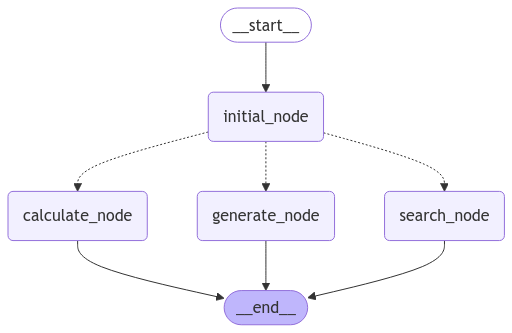

In [272]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [275]:
user_query = "What is 2+3"
result = graph.invoke({
    'query': user_query,
    'response': "",
    'intent': ""
})
print(f"User Query: {user_query}")
print(f"Agent Response: {result['response']}")

CALCULATING.....
User Query: What is 2+3
Agent Response: 2 + 3 = 5

